#Etapa 1: Importação das bibliotecas

In [4]:
import numpy as np              #lib cienfífica do python
import math                     #para ter-mos acesso a recursosd e calculos matemáticos
import re                       #porque vamos trabalhar com expressões regulares
import pandas as pd             #para carregar a base de dados
from bs4 import BeautifulSoup   #é usada pra se fazer preprocessamento em textos
from google.colab import drive  #para termos acesso de recursos do google drive
import zipfile                  #para poder descompactar arquivos .zip
import seaborn as sns           #para visualização de gráficos
import spacy as sp              #é uma lib de processamento de linguagem natural que será usada para fazer o preprocessamento em alguns textos
import string                   #vai ser usada para o pré processamento dos textos
import random                   #para números aleatórios
import matplotlib.pyplot as plt #usada para gerar gráficos
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.6.0'

In [6]:
from tensorflow.keras import layers   #para ter-mos acesso as camadas
import tensorflow_datasets as tfds    

# **Etapa 2: Pré-processamento dos dos dados**

## **Carregamento Dos Arquivos**

In [7]:
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
path = '/content/drive/MyDrive/Database/trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file = path, mode='r') #r pq será feito uma leitura
zip_object.extractall('./')
zip_object.close()

In [9]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [10]:
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header= None, names= cols, engine='python', encoding='latin1')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


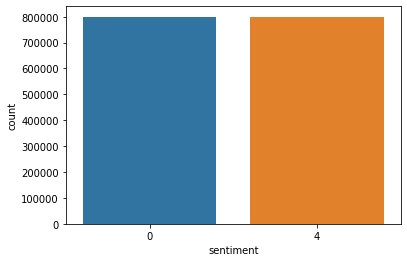

In [11]:
sns.countplot(train_data.sentiment);

In [12]:
test_data = pd.read_csv("/content/trainingandtestdata/test.csv", header=None, names=cols, engine="python", encoding="latin1")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


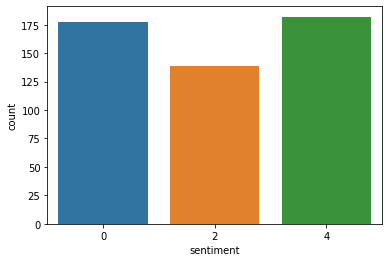

In [13]:
sns.countplot(test_data.sentiment);

## **Limpeza**

In [14]:
data = train_data #para trabalhar com essa variável

In [15]:
data.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True);

In [16]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [17]:
X = data.iloc[:, 1].values

In [18]:
X.shape
type(X)

numpy.ndarray

In [19]:
y = data.iloc[:, 0].values

In [20]:
X.shape
y

array([0, 0, 0, ..., 4, 4, 4])

In [21]:
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y) #vamos returar 85% da base de dados. X e y representam a porção de treinamento e _ e _ a porção de teste.
#esse estratify vai fazer com que seja dividido de forma igual as classes, não fique mais demais de um lado e menos no outro

In [22]:
X.shape

(240000,)

In [23]:
y.shape

(240000,)

In [24]:
unique, counts = np.unique(y, return_counts= True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [25]:
nlp = sp.load('en')
nlp

In [26]:
stop_words = sp.lang.en.STOP_WORDS #lista das palavras que podem ser removidas

In [27]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) #retirar o @user
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) #retirar a url
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet) #retirar os numeros
  tweet = re.sub(r" +", ' ', tweet) #remover os excessos de espaços

  tweet = tweet.lower() #conversão para minúsculo
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

    #remoção das stop_words e pontuações
  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])
  return words

In [28]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [29]:
text = clean_tweets(text)
text

'  awww s bummer shoulda got david carr day d'

In [30]:
data_clean = [clean_tweets(tweet) for tweet in X]

In [31]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

best vacation m looking forward going
hate waiting m usually pretty patient person doesn t usually bother starting pattern ... gahh
brady bunch wrap ending keeping kardashians
kitkat cereals breakfast
want home
  tell tweets helping stay awake night shift nearly home time xx
  sucks went uniworstity nice local resources
  lower quality version video hd skips badly netbook
home .. passed exam
  thank good luck ny ...


In [32]:
data_labels = y

In [33]:
data_labels[data_labels == 4] = 1

## **Tokenização (Transformar as letras em números)**

In [34]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16) 

In [35]:
print(tokenizer.subwords)

['  ', 's_', 'm_', 't_', ' ... ', ' .. ', 'good_', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'don_', 'u_', ' ...', 'work_', 'time_', 'today_', 'know_', 'new_', 'll_', 'want_', 'think_', 'oh_', 'need_', 'lol_', 'thanks_', 've_', 'home_', 'hope_', 'night_', 'great_', 'feel_', 'miss_', 'd_', ' .... ', 'day', 'wish_', 'twitter_', 'lol', 'morning_', 'na_', 'gon_', 'today', 'getting_', 'bad_', 'happy_', 'watching_', 'tomorrow_', 'sorry_', 'haha_', 'way_', ' ..', 'didn_', 'come_', 'sad_', 'fun_', 'sleep_', 'nice_', 'yeah_', 'n_', 'work', 'hate_', 'wait_', 'right_', 'hey_', 'people_', 'better_', 'school_', 'bed_', 'little_', 'yes_', 'having_', 'y_', 'tonight_', 'wanna_', 'week_', 'long_', 'days_', 'best_', 'thank_', 'time', 'let_', 'watch_', 'awesome_', 'feeling_', 'won_', 'e_', 'tomorrow', 'o_', 'good', 'ur_', 'looking_', 'ok_', 'sure_', 'working_', 'night', 'r_', 'find_', 'went_', 'ready_', 'trying_', 'look_', 'pretty_', 'weekend_', 'man_', 'life_', 'tired_', 'w_', 'thing_', 'love',

In [36]:
ids = tokenizer.encode("i am happy")
ids

[290, 4049, 392]

In [37]:
text_id = tokenizer.decode(ids)
text_id

'i am happy'

In [38]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [39]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[222, 673]
[33, 32, 1659, 165, 350, 5, 1403, 182, 17, 872, 90]
[149, 185, 7608, 17641, 43042, 44842, 52763, 16]
[1, 167, 5, 57, 1980, 1110]
[1, 42, 102, 70, 4, 65, 544, 268, 3234]
[578, 30, 1010]
[1, 37203, 58, 5115, 13242, 52698, 22, 17, 143]
[1, 2, 512, 264, 226]
[1, 113, 119, 3741, 2132, 365, 45]
[454, 59, 9, 20986, 13946, 91, 5397, 728, 169, 23100, 812, 7, 32, 8302, 559]


In [40]:
tokenizer.decode([32817, 848, 1392, 4437, 797, 8960, 19665, 31447, 52811])

'macswoo lately takenmothers wel neighbourhood queasy �'

## **Padding (preenchimento)**
Como há várias sentenças com tamanhos diferentes, é importante deixar todas com o mesmo tamanho.

In [41]:
max_len = max([len(sentence) for sentence in data_inputs]) #vendo quem tem o maior tamanho
max_len

49

In [42]:
#fazer o preenchimento
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, value = 0, padding = 'post', maxlen=max_len)

In [43]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[    1    72  2355    27  2505 10413 52784     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[25775   864    30    17 11339 40307     2   295  1170     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[    3    47   177     4   362    11   536  2424 14534   320     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[    1   337   466   676     2     3   570    76     2 16170  7805     0
     0     0     0     0   

## **Divisão dos dados de treino e de teste**

In [44]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs, data_labels, test_size=0.3, stratify = data_labels)
#30% para teste e 70% para treinamento

In [45]:
[train_inputs.shape, train_labels.shape]

[(168000, 49), (168000,)]

In [46]:
[test_inputs.shape, test_labels.shape]

[(72000, 49), (72000,)]

#**Etapa 3: Contruindo o Modelo**

In [47]:
class DCNN (tf.keras.Model):
  def __init__(self, vocab_size, emb_dim, nb_filters, ffn_units, nb_classes, dropout_rate, training=False, name="dcnn"):
    super(DCNN, self).__init__(name=name)

    #primeira camada é de embeding
    self.embedding = layers.Embedding(vocab_size, emb_dim)
    #gerar uma matriz com a quantidade de linhas que o vocabulário tem e 128 colunas
    #primeira camada pronta

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu') #objeto (filtro com 2 linhas)

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu') #objeto (filtro com 3 linhas)

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu') #objeto (filtro com 4 linhas)
    #camadas de convolução prontas

    #definir uma camada para fazer o pooling
    self.pool =  layers.GlobalMaxPool1D()
    #porque só vamos usar uma camada de pooling que vai extrair informação de todos os filtros feitos e no fim será feita a concatenação

    #definir agora a estrutura da rede neural densa
    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')  #a primeira camada oculta terá 512 neurônios 
    self.dropout = layers.Dropout(rate = dropout_rate) #ele vai zerar 10% dos valores da camada oculta para evitar overfiting

    #camada de saída
    self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    
  #interligar as camadas
  def call(self, inputs, training):
    x = self.embedding(inputs) #passando os textos para a camada de embeding
    x_1 = self.bigram(x) #ligando o X com a camda bigram 
    x_1 = self.pool(x_1) #ligando o x_1 com a camada de pooling
    x_2 = self.trigram(x) #ligando X com a camada trigram 
    x_2 = self.pool(x_2) #ligando x_2 com a camada de pooling
    x_3 = self.fourgram(x) #ligando x com o fourgram
    x_3 = self.pool(x_3) #ligando x_4 com a camada de pooling

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged) #ligando os dados que saem das camadas acima com a primeira camada densa
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output


# **Etapa 4: Treinamento**

## **Configurar os parâmetros**

In [48]:
vocab_size = tokenizer.vocab_size
vocab_size

52922

In [49]:
emb_dim = 200
nb_filters = 100 #trabalhar com 100 filtros (300 filtros)
ffn_units = 256 #quantidade de neurônios na camada oculta
batch_size = 64 #fazer o ajuste dos pesos em 64 e 64 registros
nb_classes = 2 #quantidade de classes
dropout_rate = 0.2 
nb_epochs = 10

## **Treinamento**

In [50]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters, ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [51]:
Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
#salvar e não ter que treinar de novo
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [53]:
#treinamento
history = Dcnn.fit(train_inputs, train_labels, batch_size = batch_size, epochs = nb_epochs, verbose = 1, validation_split = 0.10)
ckpt_manager.save()

Epoch 1/10
2363/2363 [==============================] - 529s 223ms/step - loss: 0.5015 - accuracy: 0.7534 - val_loss: 0.4799 - val_accuracy: 0.7651
Epoch 2/10
2363/2363 [==============================] - 525s 222ms/step - loss: 0.3592 - accuracy: 0.8408 - val_loss: 0.5234 - val_accuracy: 0.7547
Epoch 3/10
2363/2363 [==============================] - 526s 222ms/step - loss: 0.1830 - accuracy: 0.9244 - val_loss: 0.7534 - val_accuracy: 0.7342
Epoch 4/10
2363/2363 [==============================] - 524s 222ms/step - loss: 0.0960 - accuracy: 0.9605 - val_loss: 1.0973 - val_accuracy: 0.7259
Epoch 5/10
2363/2363 [==============================] - 524s 222ms/step - loss: 0.0663 - accuracy: 0.9722 - val_loss: 1.2749 - val_accuracy: 0.7332
Epoch 6/10
2363/2363 [==============================] - 523s 221ms/step - loss: 0.0524 - accuracy: 0.9777 - val_loss: 1.5161 - val_accuracy: 0.7255
Epoch 7/10
2363/2363 [==============================] - 523s 221ms/step - loss: 0.0439 - accuracy: 0.9812 - val_

'./ckpt-1'

# Etapa 5: Validação do Modelo

## Avaliação

In [54]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results) #erro, acurácia

1125/1125 [==============================] - 32s 28ms/step - loss: 1.9304 - accuracy: 0.7216
[1.9304229021072388, 0.7215555310249329]


In [55]:
y_pred_test = Dcnn.predict(test_inputs)

In [56]:
y_pred_test

array([[8.8960797e-02],
       [7.3592931e-01],
       [9.9994612e-01],
       ...,
       [9.9988145e-01],
       [1.8330429e-05],
       [7.3409235e-01]], dtype=float32)

In [57]:
y_pred_test = (y_pred_test > 0.5)

In [58]:
y_pred_test

array([[False],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [59]:
test_labels

array([0, 1, 0, ..., 0, 1, 1])

In [60]:
cm = confusion_matrix(test_labels, y_pred_test)
cm
#[(n de registros classificados corretamente da classe 0) (--)]
#[(--),  (n de registros classificados corretamente da classe 1)]

array([[25975, 10025],
       [10023, 25977]])

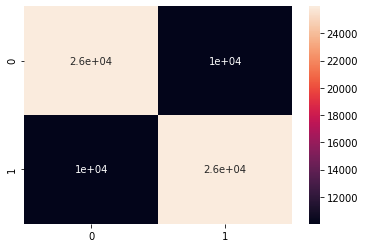

In [61]:
sns.heatmap(cm, annot=True)

In [63]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

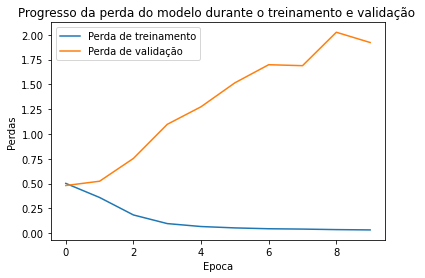

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Progresso da perda do modelo durante o treinamento e validação ')
plt.xlabel('Epoca')
plt.ylabel('Perdas')
plt.legend(['Perda de treinamento', 'Perda de validação'])

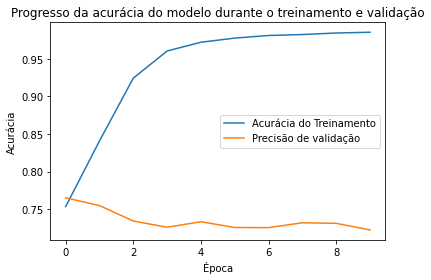

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Progresso da acurácia do modelo durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Acurácia do Treinamento', 'Precisão de validação'])

## Precisão

In [91]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[290, 64, 3413]

In [92]:
Dcnn(np.array([text]), training=False).numpy()

array([[1.9747884e-05]], dtype=float32)